## Importing packages and data

In [60]:
## Importing packages and data
# Importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import json
import os
from pathlib import Path

from subprocess import Popen, PIPE, STDOUT
from glob import glob

import langchain  # Main LangChain import
from langchain_openai import ChatOpenAI  # To work with OpenAI
# from langchain_anthropic import ChatAnthropic # To work with Anthropic (optional)
# from langchain_google_genai import ChatGoogleGenerativeAI # To work with Gemini (optional)
from langchain_core.output_parsers import JsonOutputParser  # To help with structured output
from langchain_core.prompts import PromptTemplate  # To help create our prompt
from langchain_core.pydantic_v1 import BaseModel, Field  # To help with defining what output structure we want
from pydantic import BaseModel

from typing import List, Tuple

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage
from langchain.load.dump import dumps
from langchain_core.messages import HumanMessage



import logging
import sys

import ast

In [61]:
# ==========================
# Configure Logging
# ==========================

# Create a logger
logger = logging.getLogger('ReWOO_LangGraph')
logger.setLevel(logging.DEBUG)

# Clear any existing handlers attached to the logger
if logger.hasHandlers():
    logger.handlers.clear()

# Create handlers
c_handler = logging.StreamHandler(sys.stdout)
f_handler = logging.FileHandler('rewoolanggraph.log', mode='w')

c_handler.setLevel(logging.INFO)
f_handler.setLevel(logging.DEBUG)

# Create formatters and add them to handlers
c_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)


In [62]:
# ==========================
# Function to load JSON files
# ==========================

def load_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

In [63]:
# ==========================
# Loading Files
# ==========================

base_path = 'arc-agi-genesis/data/challenges/'

# Subset of challenges for testing
subset_ids_challenges = load_json(base_path + '28_8x10_challenges.json')
subset_ids_evaluation = load_json(base_path + '28_15x15_evaluation.json')

# Load evaluation dataset
evaluation_challenges = load_json(base_path + 'arc-agi_evaluation_challenges.json')
evaluation_solutions = load_json(base_path + 'arc-agi_evaluation_solutions.json')

# load training dataset
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

# Filter training challenges and solutions to only include the subset IDs
training_challenges = {k: v for k, v in training_challenges.items() if k in subset_ids_challenges}
training_solutions = {k: v for k, v in training_solutions.items() if k in subset_ids_challenges}

# filter evaluation challenges and solutions to only include the subset IDs
evaluation_challenges = {k: v for k, v in evaluation_challenges.items() if k in subset_ids_evaluation}
evaluation_solutions = {k: v for k, v in evaluation_solutions.items() if k in subset_ids_evaluation}

test_challenges = load_json(base_path + 'arc-agi_test_challenges.json')



task_sets = {
    'training': {
        'challenges': training_challenges,
        'solutions': training_solutions,
    },
    'evaluation': {
        'challenges': evaluation_challenges,
        'solutions': evaluation_solutions,
    }
}

In [64]:
# ==========================
# Function to load tasks from a pre-loaded task set
# ==========================

def load_tasks_from_file(task_set):
    """
    Loads the tasks from the pre-loaded JSON data and returns the challenges and solutions tasks.
    """
    challenges = task_set['challenges']
    solutions = task_set['solutions']

    return challenges, solutions

In [65]:
# ==========================
# Print Dataset Information
# ==========================

print(f'Number of filtered training challenges = {len(training_challenges)}')
print(f'Number of filtered training solutions = {len(training_solutions)}')

# Loading tasks from the 'training' task set
challenges, solutions = load_tasks_from_file(task_set=task_sets['training'])
print(json.dumps(challenges['0520fde7'], indent=2))  # Accessing a specific challenge

Number of filtered training challenges = 28
Number of filtered training solutions = 28
{
  "test": [
    {
      "input": [
        [
          1,
          0,
          1,
          5,
          1,
          0,
          1
        ],
        [
          0,
          1,
          0,
          5,
          1,
          0,
          1
        ],
        [
          1,
          0,
          1,
          5,
          0,
          1,
          0
        ]
      ]
    }
  ],
  "train": [
    {
      "input": [
        [
          1,
          0,
          0,
          5,
          0,
          1,
          0
        ],
        [
          0,
          1,
          0,
          5,
          1,
          1,
          1
        ],
        [
          1,
          0,
          0,
          5,
          0,
          0,
          0
        ]
      ],
      "output": [
        [
          0,
          0,
          0
        ],
        [
          0,
          2,
          0
        ],
        [
  

#### initializing LLM client to use

In [66]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv('api.env')

# Get the OpenAI API key from environment variables
openai_api_key = os.getenv('OPENAI_API_KEY')

# Initialize the ChatOpenAI model with the API key
llm = ChatOpenAI(model='gpt-4o-mini', openai_api_key=openai_api_key, max_tokens=3000)

## And incase you want to try Anthropic
# llm = ChatAnthropic(model='claude-3-5-sonnet-20240620', api_key=UserSecretsClient().get_secret("ANTHROPIC_API_KEY"), max_tokens=3000)
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", google_api_key=UserSecretsClient().get_secret("GOOGLE_API_KEY"), max_tokens=3000)

### Function for visualizing the tasks

In [67]:
cmap = colors.ListedColormap(
   ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#FFFFFF'])
norm = colors.Normalize(vmin=0, vmax=10)
# print(norm)

def plot_one(ax, i, task, train_or_test, input_or_output):
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which = 'both', color = 'lightgrey', linewidth = 0.5)
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    ax.set_title(train_or_test + ' ' + input_or_output)
    return None
   
def plot_eval(task1, text, train_or_test='train', variants=['input', 'output']):    
    num_train = len(task1[train_or_test])
    w=num_train
    fig, axs = None, None
    fig, axs = plt.subplots(len(variants), w, figsize=(3*w ,3*2))
    plt.suptitle(f'{text}:', fontsize=20, fontweight='bold', y=1)

    for j in range(num_train):
        for v_idx, variant in enumerate(variants):
            print(v_idx, axs[v_idx], variant, j)
            plot_one(axs[v_idx], j, task1, train_or_test, variants[v_idx]) # 

    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
    plt.tight_layout()
    plt.show()
    return plt
 
def plot_task(task1, text):    
    num_train = len(task1['train'])
    w=num_train
    fig, axs  = plt.subplots(2, w, figsize=(3*w ,3*2))
    plt.suptitle(f'{text}:', fontsize=20, fontweight='bold', y=1)

    for j in range(num_train):     
        plot_one(axs[0, j], j,task1,'train', 'input')
        plot_one(axs[1, j], j,task1,'train', 'output')  
    
    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
    plt.tight_layout()
    # plt.show()
    return plt    
    
def openai_encode_image_base64(plt):
    import io
    plt_stringIObytes = io.BytesIO()
    plt.savefig(plt_stringIObytes, format='png')
    plt_stringIObytes.seek(0)
    base64_image = base64.b64encode(plt_stringIObytes.read()).decode('utf-8')
    return {
      "type": "image_url",
      "image_url": {
        "url": f"data:image/jpeg;base64,{base64_image}"
      }
    }

## Trying to make MVP product which is just regular openai model trying to predict 

In [68]:
# converting train and test pairs to a string format ideal for LLMs
def json_task_to_string(challenge_tasks: dict, task_id: str, test_input_index: int) -> str:
    """
    challenge_tasks: dict a list of tasks
    task_id: str the id of the task we want to convert to a string
    
    Convert your json task into a string so you can pass it to your LLM.
    This is a crucial step where you can use your creativity to edit how tasks are represented.
    """
    json_task = challenge_tasks[task_id]

    final_output = ""

    train_tasks = json_task['train']
    test_task = json_task['test']

    final_output = "Training Examples\n"

    for i, task in enumerate(train_tasks):
        final_output += f"Example {i + 1}: Input\n["
        for row in task['input']:
            final_output += f"\n{str(row)},"

        final_output += "]\n\n"
        final_output += f"Example {i + 1}: Output\n["

        for row in task['output']:
            final_output += f"\n{str(row)},"

        final_output += "]\n\n"

    final_output += "Test\n["
    for row in test_task[test_input_index]['input']:
        final_output += f"\n{str(row)}"

    final_output += "]\n\nYour Response:"

    return final_output

In [69]:
# an example of how the function works
task_string = json_task_to_string(challenges, '0520fde7', 0)
print (task_string)

Training Examples
Example 1: Input
[
[1, 0, 0, 5, 0, 1, 0],
[0, 1, 0, 5, 1, 1, 1],
[1, 0, 0, 5, 0, 0, 0],]

Example 1: Output
[
[0, 0, 0],
[0, 2, 0],
[0, 0, 0],]

Example 2: Input
[
[1, 1, 0, 5, 0, 1, 0],
[0, 0, 1, 5, 1, 1, 1],
[1, 1, 0, 5, 0, 1, 0],]

Example 2: Output
[
[0, 2, 0],
[0, 0, 2],
[0, 2, 0],]

Example 3: Input
[
[0, 0, 1, 5, 0, 0, 0],
[1, 1, 0, 5, 1, 0, 1],
[0, 1, 1, 5, 1, 0, 1],]

Example 3: Output
[
[0, 0, 0],
[2, 0, 0],
[0, 0, 2],]

Test
[
[1, 0, 1, 5, 1, 0, 1]
[0, 1, 0, 5, 1, 0, 1]
[1, 0, 1, 5, 0, 1, 0]]

Your Response:


In [70]:
# Using a json output parser to parse the output, since LLMs aren't perfect at generating valid json
# Defining a prediction as a list of lists
class ARCPrediction(BaseModel):
    prediction: List[List] = Field(..., description="A prediction for a task")

## Setting up langgraph for mUlTiaGenTiC sYstEM

In [71]:
# Setting up the state for the graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    patterns: Annotated[list, add_messages]
    code: str
    prediction: List[List]
    task_string: str
    task_data: dict
    test_input_index: int



#### Generating nodes

In [72]:
# Building nodes for the graph
# first initialize the StateGraph
graph_builder = StateGraph(State)
import ast

# ==========================
# Function to get the grid size prediction. Has 86% accuracy on the training set.
# ==========================
def predict_task_grid_size(train_inputs, train_outputs, test_inputs):
    """
    Predicts the grid size of test inputs based on patterns from the train inputs and outputs.

    Args:
    - train_inputs: List of 2D arrays representing the input grids for training.
    - train_outputs: List of 2D arrays representing the output grids for training.
    - test_inputs: List of 2D arrays representing the input grids for testing.

    Returns:
    - pred_test_sizes: List of predicted sizes for the test outputs in 'WxH' format (e.g., '6x6').
    """

    # Calculate the sizes of train inputs and outputs
    train_in_size = [[len(i[0]), len(i)] for i in train_inputs]
    train_out_size = [[len(i[0]), len(i)] for i in train_outputs]

    # Calculate the sizes of test inputs
    test_in_size = [[len(i[0]), len(i)] for i in test_inputs]

    # Try to detect consistent ratio patterns
    ratio_x = train_in_size[0][0] / train_out_size[0][0]
    ratio_y = train_in_size[0][1] / train_out_size[0][1]

    # Check for consistent ratios in the training set
    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if in_size[0] / out_size[0] != ratio_x or in_size[1] / out_size[1] != ratio_y:
            break
    else:
        # If the ratio holds, predict based on the ratio
        pred_test_sizes = [f"{int(i[0] / ratio_x)}x{int(i[1] / ratio_y)}" for i in test_in_size]
        return pred_test_sizes

    # If ratio-based prediction fails, check for consistent subtraction patterns
    sub_x = train_in_size[0][0] - train_out_size[0][0]
    sub_y = train_in_size[0][1] - train_out_size[0][1]

    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if in_size[0] - out_size[0] != sub_x or in_size[1] - out_size[1] != sub_y:
            break
    else:
        # If subtraction holds, predict based on subtraction
        pred_test_sizes = [f"{i[0] - sub_x}x{i[1] - sub_y}" for i in test_in_size if i[0] - sub_x > 0 and i[1] - sub_y > 0]
        return pred_test_sizes

    # If subtraction-based prediction fails, predict based on the size of the last output grid
    last_x = train_out_size[0][0]
    last_y = train_out_size[0][1]

    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if out_size[0] != last_x or out_size[1] != last_y:
            break
    else:
        # If all output grids are the same size, predict this size for all test inputs
        pred_test_sizes = [f"{last_x}x{last_y}" for _ in test_in_size]
        return pred_test_sizes

    # If no pattern holds, return 'Unknown' indicating an unknown prediction
    pred_test_sizes = ['Unknown' for _ in test_in_size]
    return pred_test_sizes



# ==========================
# Helper Function to Convert Messages
# ==========================

def convert_messages(message_list):
    return [
        msg.content if isinstance(msg, (AIMessage, HumanMessage)) else str(msg)
        for msg in message_list
    ]

def make_serializable(obj):
    if isinstance(obj, (AIMessage, HumanMessage)):
        return obj.content
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: make_serializable(value) for key, value in obj.items()}
    else:
        return obj  # Assume the object is already serializable

# ==========================
# execute_code with Syntax Checking and Logging
# ==========================

def execute_code(state: State):
    code = state['code']
    task_data = state['task_data']

    test_input_index = state['test_input_index']
    test_input = task_data['test'][test_input_index]['input']

    # Log the code for debugging
    logger.debug(f"Executing code:\n{code}")

    # Syntax check
    try:
        ast.parse(code)
    except SyntaxError as se:
        logger.error(f"Syntax error in generated code: {se.text}\n"
                     f"Error at line {se.lineno}, column {se.offset}\n"
                     f"Line content: {se.text}")
        return {"prediction": [], "revised_code": code}

    local_vars = {}
    global_vars = {}

    try:
        exec(code, global_vars, local_vars)
        if 'solve_task' in local_vars:
            solve_task = local_vars['solve_task']
        elif 'solve_task' in global_vars:
            solve_task = global_vars['solve_task']
        else:
            raise Exception("solve_task function not defined in code.")

        prediction = solve_task(test_input)
    except Exception as e:
        prediction = []
        logger.error(f"Error executing code: {e}")

    return {"prediction": prediction, "revised_code": code}

# ==========================
# generate_code with Enhanced Prompt
# ==========================

import re  # Import this at the top of your file to use regex for stripping

def clean_code_output(code: str) -> str:
    """
    Function to clean up the code generated by the LLM.
    Strips out markdown-like syntax like ```python and ```.
    """
    # Use regex to remove markdown code block markers and unnecessary spaces
    cleaned_code = re.sub(r'```[\w]*', '', code).strip()
    return cleaned_code

def generate_code(state: State):
    patterns = state['patterns'][-1]  # Get the last patterns added

    prompt = PromptTemplate(
        template=(
            "You are an expert Python programmer.\n\n"
            "Given the following patterns, write Python code that solves the task according to these patterns.\n"
            "The code should define a function `solve_task(input_grid)` that returns the output grid.\n"
            "Ensure the code is syntactically correct and free of any errors.\n\n"
            "**ONLY** return the code without any additional explanations.\n\n"
            "Patterns:\n{patterns}\n\n"
            "Your code:"
        ),
        input_variables=["patterns"]
    )

    chain = prompt | llm
    code = chain.invoke({"patterns": patterns}).content.strip()

    # Clean up the generated code by removing any markdown formatting
    cleaned_code = clean_code_output(code)

    return {"code": cleaned_code}

def revise_code(state: State):
    code = state['code']

    prompt = PromptTemplate(
        template=(
            "Review the following Python code and improve it if necessary.\n"
            "Ensure that it correctly implements the desired functionality and handles edge cases.\n\n"
            "**ONLY** return the revised code without any explanations or comments.\n\n"
            "Code:\n{code}\n\n"
            "Revised code:"
        ),
        input_variables=["code"]
    )

    chain = prompt | llm
    revised_code = chain.invoke({"code": code}).content.strip()

    # Clean up the revised code by removing any markdown formatting
    cleaned_revised_code = clean_code_output(revised_code)

    return {"code": cleaned_revised_code}


# ==========================
# identify_logic Function
# ==========================

def identify_logic(state: State):
    task_string = state['task_string']
    predicted_grid_size = state.get('predicted_grid_size', 'Unknown')  # Retrieve the predicted grid size from the state
    
    # Add the grid size information to the prompt for the LLM
    logger.info(f"Identifying logic for task: {task_string} with predicted grid size: {predicted_grid_size}")
    prompt = PromptTemplate(
        template=(
            "You are an AI assistant specializing in puzzle solving.\n\n"
            "The predicted grid size for this task is {predicted_grid_size}.\n"
            "Given the following task, identify the logic or pattern present in the training examples.\n"
            "Provide a brief description of the logic in bullet points.\n\n"
            "Task:\n{task_string}\n\n"
            "Your response should be a brief description of the logic."
        ),
        input_variables=["task_string", "predicted_grid_size"]
    )

    chain = prompt | llm
    output = chain.invoke({
        "task_string": task_string,
        "predicted_grid_size": predicted_grid_size
    }).content

    # Return as AIMessage object
    return {"messages": [AIMessage(content=output)]}


# ==========================
# recognize_patterns Function
# ==========================

def recognize_patterns(state: State):
    messages = state['messages']
    previous_analysis = messages[-1]  # Already converted to string in get_task_prediction

    prompt = PromptTemplate(
        template=(
            "Based on the previous analysis, identify detailed patterns in the task.\n"
            "Focus on visual patterns, JSON structures, or any other relevant aspects.\n"
            "Provide the patterns as a list of concise statements.\n\n"
            "Previous analysis:\n{previous_analysis}\n\n"
            "Your response should be a list of patterns."
        ),
        input_variables=["previous_analysis"]
    )

    chain = prompt | llm
    output = chain.invoke({"previous_analysis": previous_analysis}).content

    return {"patterns": [output]}


#### Building the graph with eches

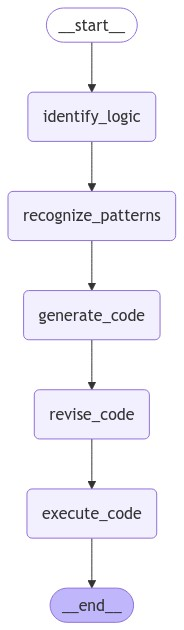

In [73]:
graph_builder.add_node("identify_logic", identify_logic)
graph_builder.add_node("recognize_patterns", recognize_patterns)
graph_builder.add_node("generate_code", generate_code)
graph_builder.add_node("revise_code", revise_code)
graph_builder.add_node("execute_code", execute_code)

graph_builder.add_edge(START, "identify_logic")
graph_builder.add_edge("identify_logic", "recognize_patterns")
graph_builder.add_edge("recognize_patterns", "generate_code")
graph_builder.add_edge("generate_code", "revise_code")
graph_builder.add_edge("revise_code", "execute_code")
graph_builder.add_edge("execute_code", END)

graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Creating function to get task prediction, make prompt, make API calls to model and parse output with retries

In [74]:
def get_task_prediction(challenge_tasks, task_id, test_input_index) -> dict:
    task_string = json_task_to_string(challenge_tasks, task_id, test_input_index)
    task_data = challenge_tasks[task_id]
    
    train_tasks = task_data['train']
    train_inputs = [t['input'] for t in train_tasks]
    train_outputs = [t['output'] for t in train_tasks]
    test_inputs = [task_data['test'][test_input_index]['input']]
    
    # Predict the grid size
    predicted_grid_size = predict_task_grid_size(train_inputs, train_outputs, test_inputs)[0]  # Get the first prediction
    
    initial_state = {
        'task_string': task_string,
        'task_data': task_data,
        'test_input_index': test_input_index,
        'predicted_grid_size': predicted_grid_size,  # Add predicted grid size to the state
        'messages': [],
        'patterns': [],
        'code': '',
        'revised_code': '',
        'prediction': []
    }

    final_state = graph.invoke(initial_state)

    # Convert AIMessage objects to their content strings
    messages = final_state.get('messages', [])
    if messages:
        messages = [msg.content if isinstance(msg, AIMessage) else msg for msg in messages]

    output_details = {
        'messages': messages,
        'patterns': final_state.get('patterns', []),
        'code': final_state.get('code', ''),
        'revised_code': final_state.get('revised_code', ''),
        'prediction': final_state.get('prediction', [])
    }

    return output_details


In [75]:
def run_model(challenges, NUM_ATTEMPTS=2, RETRY_ATTEMPTS=3, NUM_TASKS=None):
    """
    challenges: dict a list of challenges. This should come directly from your _challenges file
    NUM_ATTEMPTS: int the number of times to attempt a prediction. The official competition has 2 attempts.
    RETRY_ATTEMPTS: int the number of times to retry a prediction if it fails
    NUM_TASKS: int, If set, this represents the number of tasks you'd like to test. If None then all challenges will be tested

    Loop through your challenges and produce a submission.json file you can submit for a score.
    """

    # A dict to hold your submissions that you'll return after all predictions are made
    submission = {}
    detailed_outputs = {}

    # Run through each task in your challenge set
    for i, task_id in enumerate(challenges):
        task_attempts = []  # List to store all attempts for the current task
        detailed_outputs[task_id] = []

        # Go through each test pair to get a prediction. 96% of challenges have 1 pair.
        for t, pair in enumerate(challenges[task_id]['test']):
            logger.info(f"Starting task #{i + 1} ({task_id}), pair #{t+1}")

            # Dictionary to store attempts for the current test pair
            pair_attempts = {}
            pair_detailed = {}

            # Run through each prediction attempt
            for attempt in range(1, NUM_ATTEMPTS + 1):
                attempt_key = f"attempt_{attempt}"
                pair_attempts[attempt_key] = []  # Init your attempt
                pair_detailed[attempt_key] = {}

                # Try to get a prediction, with retries in case of failure
                for retry in range(RETRY_ATTEMPTS):
                    try:
                        logger.info(f"    Predicting attempt #{attempt}, retry #{retry + 1}")
                        prediction_details = get_task_prediction(
                            challenge_tasks=challenges,
                            task_id=task_id,
                            test_input_index=t
                        )

                        # If you get a valid prediction (list of lists of ints) with no error, then log the attempt
                        pair_attempts[attempt_key] = prediction_details['prediction']
                        pair_detailed[attempt_key] = prediction_details
                        break  # Break the retry loop if prediction is successful
                    except Exception as e:
                        logger.warning(f"Retrying: {e}")
                        if retry == RETRY_ATTEMPTS - 1:
                            pair_attempts[attempt_key] = []  # Assign empty list if all retries fail
                            pair_detailed[attempt_key] = {'error': str(e)}

            # After you get your attempts, append them to the task attempts
            task_attempts.append(pair_attempts)
            detailed_outputs[task_id].append(pair_detailed)

    # Append the task attempts to the submission with the task_id as the key
        submission[task_id] = task_attempts

        # If you want to stop after N tasks, uncomment the below
        if NUM_TASKS is not None and i + 1 == NUM_TASKS:
            break

    # Optionally, save detailed outputs using LangChain's dumps function
    with open('detailed_outputs.json', 'w') as f:
        serialized_outputs = dumps(detailed_outputs, pretty=True)
        f.write(serialized_outputs)


    # Option 2: Using Custom JSON Encoder (Comment out Option 1 if using this)
    # with open('detailed_outputs.json', 'w') as f:
    #     json.dump(detailed_outputs, f, indent=2, cls=CustomJSONEncoder)

    return submission

### Creating submission files and comparing it with solutions file

In [76]:
# create submission file
def create_submission_file(submission, file_name='submission.json'):
    """
    Save a submission file to the specified file name
    """
    with open(file_name, "w") as file:
        json.dump(submission, file)

    print (f"Submission saved to {file_name}")

In [77]:
# create function to compare submission with solutions
def score_submission(submission_file_name, solutions) -> Tuple[float, int]:
    """
    submission_file_name: str, the file name of your submission file
    solutions: dict, the ground truth solutions you'd like to test against
    
    Read a submission from file, score it, then return the score
    """
    print (f"Scoring {submission_file_name}\n")

    # Open your submission file
    with open(submission_file_name, "r") as file:
        submission = json.load(file)

    total_score = 0
    total_tasks = 0

    # Loop through each task in your submission to grade it
    for task_id, task_submission in submission.items():
        total_tasks += 1
        task_score = 0
        num_pairs = len(task_submission)

        # Go through each task. Most will only have 1
        for pair_index, pair_attempts in enumerate(task_submission):
            print(f"Scoring Task {task_id} pair #{pair_index+1}")
            pair_correct = False

            # Look at both of your attempts
            for attempt_key, attempt in pair_attempts.items():
                
                # check to see if one is correct
                if attempt == solutions[task_id][pair_index]:
                    print(f"Task Id {task_id} pair {pair_index+1} {attempt_key} matches solution")
                    pair_correct = True
                    break # If it is correct, log it and break the loop

            if pair_correct:
                task_score += 1

        task_score /= num_pairs
        total_score += task_score

    return {
        'total_score': total_score,
        'total_tasks_scored': total_tasks
    }

#### The main function to bring everything together

In [78]:
def main(task_set='training', NUM_TASKS=None, submission_file_name='submission.json'):
    # Load datasets
    challenges, solutions = load_tasks_from_file(task_set=task_sets[task_set])

    # Run the model
    submission = run_model(challenges, NUM_TASKS=NUM_TASKS)

    # Create (and overwrite) a submission file
    create_submission_file(submission, file_name=submission_file_name)

    # Score the submission
    score_result = score_submission(solutions=solutions, submission_file_name=submission_file_name)

    logger.info(f"Final score: {score_result['total_score']} of {score_result['total_tasks_scored']} ({round(score_result['total_score']/score_result['total_tasks_scored'] * 100, 2)}%)")

    # Optionally, load and display detailed outputs
    try:
        with open('detailed_outputs.json', 'r') as f:
            detailed_outputs = json.load(f)
        # For example, print the detailed outputs
        print(json.dumps(detailed_outputs, indent=2))
    except Exception as e:
        logger.error(f"Error loading detailed outputs: {e}")


# RUNNING THE MODEL

In [79]:
main(task_set='evaluation', NUM_TASKS=3)

2024-10-28 11:14:39,646 - INFO - Starting task #1 (00576224), pair #1
2024-10-28 11:14:39,648 - INFO -     Predicting attempt #1, retry #1
2024-10-28 11:14:39,650 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 6],
[6, 4],]

Example 1: Output
[
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],
[6, 8, 6, 8, 6, 8],
[4, 6, 4, 6, 4, 6],
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],]

Example 2: Input
[
[7, 9],
[4, 3],]

Example 2: Output
[
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],
[9, 7, 9, 7, 9, 7],
[3, 4, 3, 4, 3, 4],
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],]

Test
[
[3, 2]
[7, 8]]

Your Response: with predicted grid size: Unknown
2024-10-28 11:14:46,154 - INFO -     Predicting attempt #2, retry #1
2024-10-28 11:14:46,156 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 6],
[6, 4],]

Example 1: Output
[
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],
[6, 8, 6, 8, 6, 8],
[4, 6, 4, 6, 4, 6],
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],]

Example 2: Input
[
[7, 9]